In [ ]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools
from PIL import Image

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


In [ ]:
data_dir = '/content/drive/MyDrive/Colab Notebooks/dataset/natural_images'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
data_dir = pd.concat([Fseries, Lseries], axis= 1)

In [ ]:
# train dataframe
train_df, dummy_df = train_test_split(data_dir,  train_size= 0.8, shuffle= True, random_state= 123)

# valid and test dataframe
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.6, shuffle= True, random_state= 123)



In [ ]:
# crobed image size
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()
train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 5579 validated image filenames belonging to 8 classes.
Found 837 validated image filenames belonging to 8 classes.
Found 558 validated image filenames belonging to 8 classes.


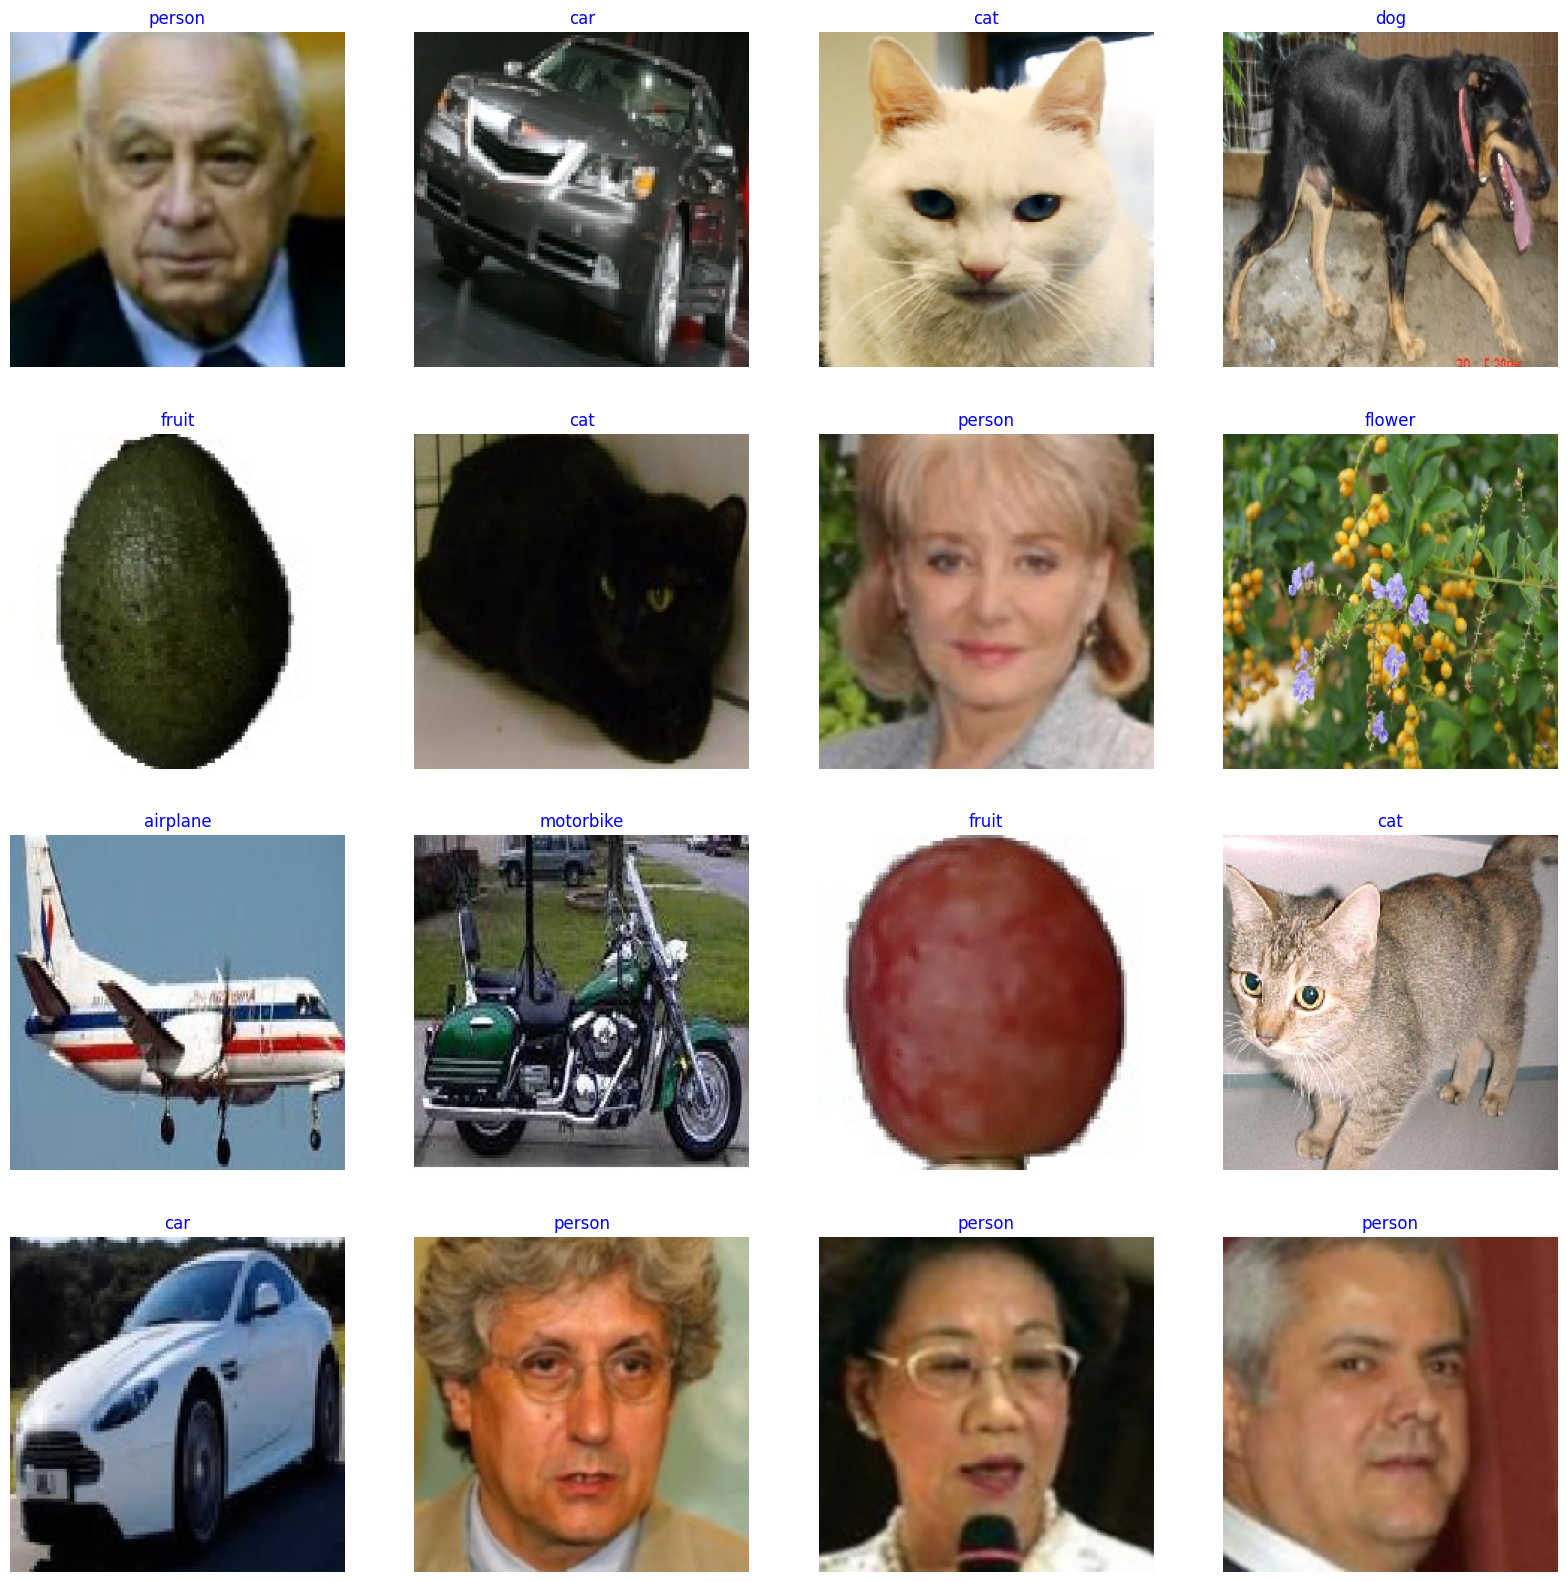

In [ ]:
g_dict = train_gen.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_gen)      # get a batch size samples from the generator

plt.figure(figsize= (20, 20))

for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255       # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    class_name = classes[index]   # get class of image
    plt.title(class_name, color= 'blue', fontsize= 12)
    plt.axis('off')
plt.show()

In [ ]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')
model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 1280)                │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 1280)                │           5,120 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 8)                   │           2,056 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,384,683 (16.73 MB)

 Trainable params: 4,340,100 (16.56 MB)

 Non-trainable params: 44,583 (174.16 KB)

In [ ]:
batch_size = 20   # set batch size for training
epochs =  20  # number of all epochs in training

history = model.fit(x= train_gen, epochs= epochs, verbose= 1, validation_data= valid_gen,
                    validation_steps= None, shuffle= False)


Epoch 1/20
349/349 ━━━━━━━━━━━━━━━━━━━━ 1884s 5s/step - accuracy: 0.5117 - loss: 11.4915 - val_accuracy: 0.2593 - val_loss: 6.6386
Epoch 2/20
349/349 ━━━━━━━━━━━━━━━━━━━━ 32s 91ms/step - accuracy: 0.2627 - loss: 5.7377 - val_accuracy: 0.2234 - val_loss: 4.6282
Epoch 3/20
349/349 ━━━━━━━━━━━━━━━━━━━━ 40s 90ms/step - accuracy: 0.2548 - loss: 4.1775 - val_accuracy: 0.2748 - val_loss: 3.3544
Epoch 4/20
349/349 ━━━━━━━━━━━━━━━━━━━━ 32s 92ms/step - accuracy: 0.2737 - loss: 3.1749 - val_accuracy: 0.2425 - val_loss: 2.7877
Epoch 5/20
349/349 ━━━━━━━━━━━━━━━━━━━━ 32s 91ms/step - accuracy: 0.2674 - loss: 2.5860 - val_accuracy: 0.4277 - val_loss: 2.2174
Epoch 6/20
349/349 ━━━━━━━━━━━━━━━━━━━━ 31s 89ms/step - accuracy: 0.3841 - loss: 2.1929 - val_accuracy: 0.4277 - val_loss: 1.9776
Epoch 7/20
349/349 ━━━━━━━━━━━━━━━━━━━━ 31s 90ms/step - accuracy: 0.4065 - loss: 1.9801 - val_accuracy: 0.5293 - val_loss: 1.7093
Epoch 8/20
349/349 ━━━━━━━━━━━━━━━━━━━━ 35s 99ms/step - accuracy: 0.6553 - loss: 1.7476 -

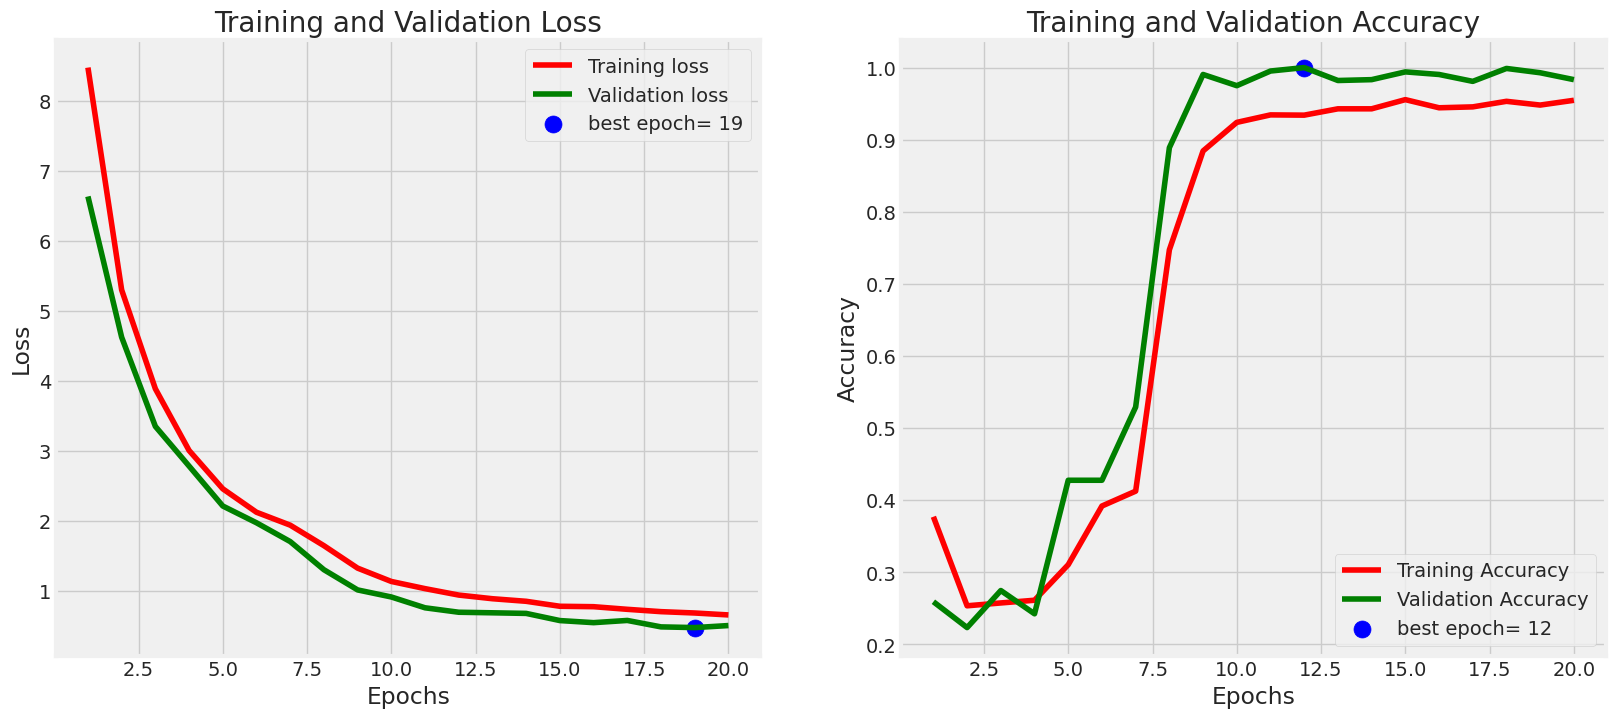

In [ ]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'
# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')
plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout
plt.show()

In [ ]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.9685 - loss: 0.5391
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.9831 - loss: 0.5069
9/9 ━━━━━━━━━━━━━━━━━━━━ 29s 4s/step - accuracy: 0.9909 - loss: 0.5040
Train Loss:  0.5382081866264343
Train Accuracy:  0.9722222089767456
--------------------
Validation Loss:  0.5137730836868286
Validation Accuracy:  0.9791666865348816
--------------------
Test Loss:  0.50555819272995
Test Accuracy:  0.9861111044883728


In [ ]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

35/35 ━━━━━━━━━━━━━━━━━━━━ 112s 3s/step


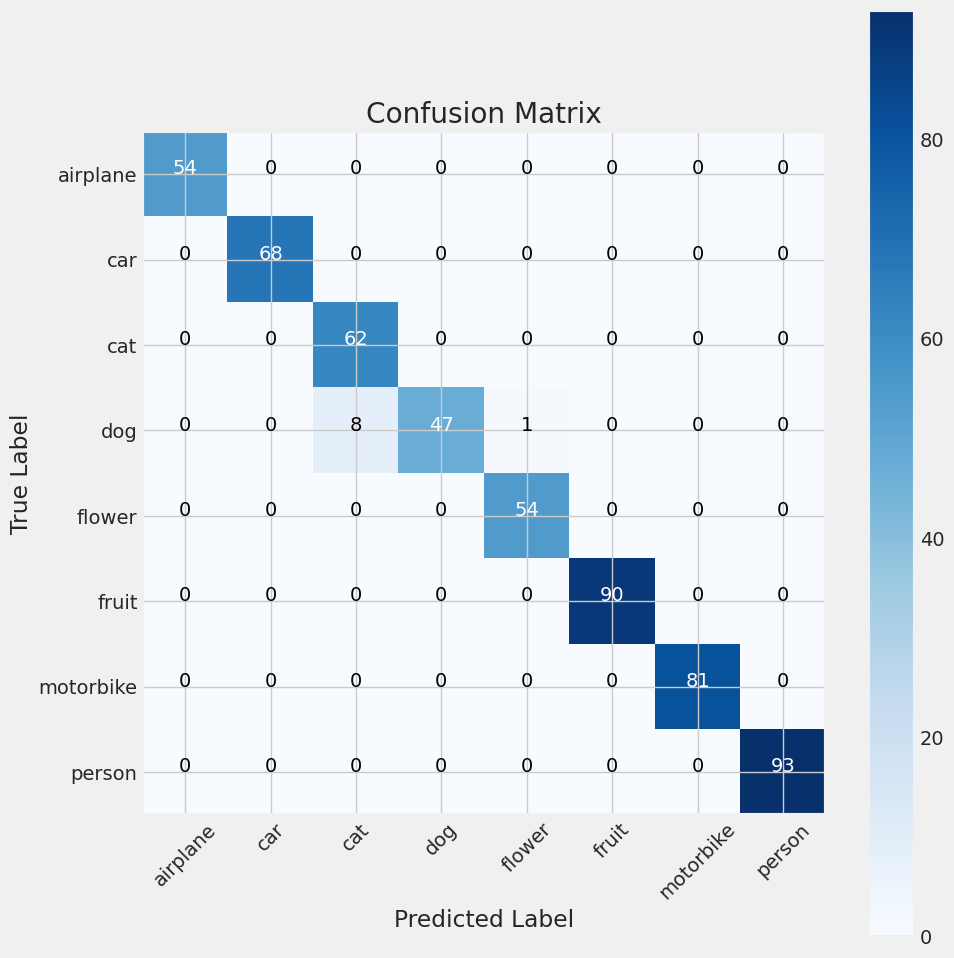

In [ ]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [ ]:
#Save the model
model.save('/content/drive/MyDrive/Colab Notebooks/Models/Natural/DL_National.keras')

In [ ]:
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Models/Natural/DL_National.keras', compile=False)
loaded_model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

In [ ]:
test_dir = '/content/drive/MyDrive/Colab Notebooks/test'
filepaths = []
labels = []

folds = os.listdir(test_dir)
for fold in folds:
    foldpath = os.path.join(test_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
test_dir = pd.concat([Fseries, Lseries], axis= 1)

# crobed image size
batch_size = 16
img_size = (224, 224)
channels = 3

ts_gen = ImageDataGenerator()
img_shape = (img_size[0], img_size[1], channels)

test_gen = ts_gen.flow_from_dataframe(test_dir, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

test_gen.class_indices

Found 75 validated image filenames belonging to 2 classes.


{'cat': 0, 'dog': 1}

In [ ]:
train_gen.class_indices

{'airplane': 0,
 'car': 1,
 'cat': 2,
 'dog': 3,
 'flower': 4,
 'fruit': 5,
 'motorbike': 6,
 'person': 7}

In [ ]:
# Dự đoán trên tập test
predictions = loaded_model.predict(test_gen)
predictions

5/5 ━━━━━━━━━━━━━━━━━━━━ 44s 9s/step


array([[9.29961097e-04, 9.45706444e-04, 9.82475102e-01, 7.68220657e-03,
        3.35722789e-03, 1.13198929e-03, 1.25317904e-03, 2.22460413e-03],
       [2.87028495e-03, 3.05802142e-03, 9.55737591e-01, 1.70937367e-02,
        8.47311597e-03, 3.32549191e-03, 3.66479065e-03, 5.77706145e-03],
       [2.45905900e-03, 2.58048903e-03, 9.61533844e-01, 1.51097719e-02,
        7.22466875e-03, 2.86580762e-03, 3.12495395e-03, 5.10129146e-03],
       [3.68785369e-03, 3.94426053e-03, 9.46685314e-01, 2.01938003e-02,
        9.93851107e-03, 4.12445702e-03, 4.48590331e-03, 6.93980372e-03],
       [2.39859126e-03, 2.47445563e-03, 9.63982880e-01, 1.44866658e-02,
        6.40747091e-03, 2.67126947e-03, 2.83428677e-03, 4.74429922e-03],
       [2.70506740e-03, 2.87928898e-03, 9.58076239e-01, 1.64429247e-02,
        8.01288523e-03, 3.09647783e-03, 3.41238314e-03, 5.37474314e-03],
       [1.65824071e-02, 1.88527387e-02, 8.07400107e-01, 5.60106486e-02,
        3.50186490e-02, 1.86478365e-02, 2.02305429e-02, 2.

In [ ]:
cat_index = train_gen.class_indices["cat"]
dog_index = train_gen.class_indices["dog"]

print("Index của cat:", cat_index)
print("Index của dog:", dog_index)

Index của cat: 2
Index của dog: 3


In [ ]:
# Chỉ lấy xác suất của cat và dog
cat_dog_probs = predictions[:, [cat_index, dog_index,]]

cat_dog_probs

array([[0.9824751 , 0.00768221],
       [0.9557376 , 0.01709374],
       [0.96153384, 0.01510977],
       [0.9466853 , 0.0201938 ],
       [0.9639829 , 0.01448667],
       [0.95807624, 0.01644292],
       [0.8074001 , 0.05601065],
       [0.966243  , 0.01357116],
       [0.9498669 , 0.01889214],
       [0.96802527, 0.01316684],
       [0.9778792 , 0.00945604],
       [0.95590776, 0.01704342],
       [0.99049604, 0.00450492],
       [0.92498434, 0.02656664],
       [0.93375236, 0.0237983 ],
       [0.934575  , 0.02367279],
       [0.9701301 , 0.01221794],
       [0.90720546, 0.03513305],
       [0.92901593, 0.02527533],
       [0.98254746, 0.00784338],
       [0.87691325, 0.03986672],
       [0.981611  , 0.0080769 ],
       [0.9566083 , 0.01686434],
       [0.9632001 , 0.01457081],
       [0.9549119 , 0.01728331],
       [0.9726343 , 0.01132032],
       [0.9809334 , 0.00847062],
       [0.9181214 , 0.0283004 ],
       [0.9526471 , 0.0182968 ],
       [0.9778144 , 0.00950303],
       [0.

In [ ]:
# Lấy nhãn dự đoán (0: cat, 1: dog)
predicted_labels = np.argmax(cat_dog_probs, axis=1)

# Lấy nhãn thực tế từ test_generator
true_labels = test_gen.classes  # Tự động gán số (cat = 0, dog = 1)

# Tính độ chính xác
accuracy = np.mean(predicted_labels == true_labels)
print(f"Test Accuracy: {accuracy:.4%}")

Test Accuracy: 94.6667%


In [ ]:
num_classes = loaded_model.output_shape[-1]
print("Số lượng nhãn trong mô hình:", num_classes)

Số lượng nhãn trong mô hình: 8
